In [1]:
!pip install -q scikit-learn pandas matplotlib

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline



In [4]:


data_path = "/content/forums_labeled_data.csv"
df = pd.read_csv(data_path)

print(df.head())
print(df.columns)


   topic_id                                        title_topic  label  \
0        38  (@Tha_BackEnd_Plug)BUY QAULITY COUNTERFEIT BAN...      0   
1       137  ❤️I have a paypal verified CC WU account with ...      0   
2       166  | guns for sale| buy weapons online (TELEGRAM:...      0   
3       270  ❤️ identification documents from anywhere in t...      0   
4       280  *Bank accounts hack  *Twitters hack *email acc...      1   

   post_id       dateinserted_post  \
0       61  2023-09-20 00:00:00-07   
1      168  2023-09-20 00:00:00-07   
2      233  2023-09-20 00:00:00-07   
3      343  2023-09-20 00:00:00-07   
4      354  2023-09-20 00:00:00-07   

                                        content_post  
0  Contact via telegram handle above for inquirie...  
1  We produces registered and authentic documents...  
2  Are you Looking for a SECURED DARK-WEB SHOP FO...  
3  We produces registered and authentic documents...  
4  Are you looking for the Best reliable and legi...  
In

In [8]:
import re
import numpy as np

# --- sanity check: make sure expected columns exist ---
print("Columns in df:", df.columns.tolist())

required_cols = ["topic_id", "title_topic", "label", "content_post"]
missing = [c for c in required_cols if c not in df.columns]

if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# fill missing text fields
df["title_topic"] = df["title_topic"].fillna("")
df["content_post"] = df["content_post"].fillna("")

# --- group posts by thread (topic_id) ---
threads = (
    df.groupby(["topic_id", "title_topic", "label"])["content_post"]
      .apply(list)
      .reset_index()
)

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)     # remove URLs
    text = re.sub(r"\S+@\S+", " ", text)             # remove emails
    text = re.sub(r"[^a-z0-9\s]", " ", text)         # keep only letters/numbers/space
    text = re.sub(r"\s+", " ", text).strip()         # collapse spaces
    return text

def build_thread_text(title, posts):
    title = clean_text(title)
    posts = [clean_text(p) for p in posts if isinstance(p, str)]

    if not posts:
        return title

    # simple strategy: title + first post + longest post (trimmed)
    first = posts[0]
    longest = max(posts, key=len)

    combined = title + " " + first + " " + longest[:1000]
    return combined

threads["text"] = threads.apply(
    lambda row: build_thread_text(row["title_topic"], row["content_post"]),
    axis=1
)

# final features and labels
X_text = threads["text"].tolist()
y = threads["label"].astype(int).values

print("Number of threads:", len(X_text))
print("Positive rate:", y.mean())
print("\nSample thread text:\n", X_text[0][:400])


Columns in df: ['topic_id', 'title_topic', 'label', 'post_id', 'dateinserted_post', 'content_post']
Number of threads: 1000
Positive rate: 0.474

Sample thread text:
 qaulity counterfeit banknotes contact via telegram handle above for inquiries we print and produce so many different currencies but specialize on producing the euro usdollars canadian dollars british pounds australian dollars and swiss franc our bills are all top quality grade aaa and are perfectly reproduced indistinguishable to the eye and touch and carries all holograms holographic strips water


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

# --- compute class weights (helps with imbalance) ---
classes = np.unique(y)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

# --- TF-IDF + Logistic Regression pipeline ---
tfidf_logreg_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.9,
        max_features=50000,
        sublinear_tf=True,
    )),
    ("clf", LogisticRegression(
        C=2.0,
        class_weight=class_weight_dict,
        max_iter=2000,
        n_jobs=-1
    ))
])

# --- 5-fold stratified cross-validation ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Out-of-fold predicted probabilities for the positive class
probs_oof = cross_val_predict(
    tfidf_logreg_pipeline,
    X_text,
    y,
    cv=skf,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

print("probs_oof shape:", probs_oof.shape)

# --- Baseline F1-score using threshold = 0.5 ---
y_pred_05 = (probs_oof >= 0.5).astype(int)
baseline_f1 = f1_score(y, y_pred_05)
print("Baseline F1 at threshold 0.5:", baseline_f1)


Class weights: {np.int64(0): np.float64(0.9505703422053232), np.int64(1): np.float64(1.0548523206751055)}
probs_oof shape: (1000,)
Baseline F1 at threshold 0.5: 0.7653508771929824


Best threshold: 0.47000000000000003
Best F1 at that threshold: 0.7736625514403292
Improvement over F1 at threshold 0.5: 0.0083116742473468


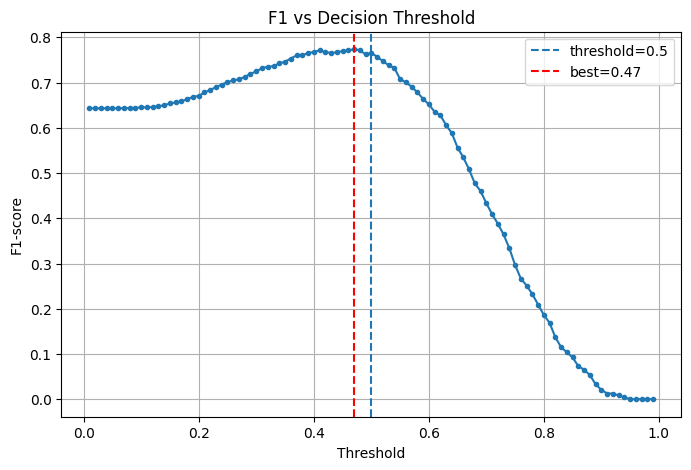


Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0     0.8048    0.7681    0.7860       526
           1     0.7550    0.7932    0.7737       474

    accuracy                         0.7800      1000
   macro avg     0.7799    0.7807    0.7798      1000
weighted avg     0.7812    0.7800    0.7801      1000

Confusion Matrix (rows=true, cols=pred):
[[404 122]
 [ 98 376]]


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

thresholds = np.linspace(0.01, 0.99, 99)
f1_scores = []

for t in thresholds:
    y_pred = (probs_oof >= t).astype(int)
    f1_scores.append(f1_score(y, y_pred))

f1_scores = np.array(f1_scores)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print("Best threshold:", best_threshold)
print("Best F1 at that threshold:", best_f1)
print("Improvement over F1 at threshold 0.5:", best_f1 - baseline_f1)

# --- Plot F1 vs threshold ---
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker=".")
plt.axvline(0.5, linestyle="--", label="threshold=0.5")
plt.axvline(best_threshold, color='red', linestyle="--", label=f"best={best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1 vs Decision Threshold")
plt.legend()
plt.grid(True)
plt.show()

# --- Detailed performance at best threshold ---
y_pred_best = (probs_oof >= best_threshold).astype(int)

print("\nClassification Report (Best Threshold):")
print(classification_report(y, y_pred_best, digits=4))

print("Confusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y, y_pred_best))


In [11]:
# --- Train final model on ALL data ---
final_pipeline = tfidf_logreg_pipeline.fit(X_text, y)

print("Final model trained on all data.")
print("Using optimized threshold:", best_threshold)

def predict_thread_probability(text):
    """
    Returns P(class=1 | text) for a single thread.
    """
    return float(final_pipeline.predict_proba([text])[0, 1])

def predict_thread_label(text):
    """
    Returns 1 (criminal hacking) or 0 (not)
    using the optimized threshold found in Cell 5.
    """
    prob = predict_thread_probability(text)
    return int(prob >= best_threshold)

# --- Test with an example ---
example_title = "Any working exploit packs?"
example_posts = [
    "Looking for browser exploit kits.",
    "PM me if you have 0day or fresher packs."
]

example_text = example_title + " " + " ".join(example_posts)

p = predict_thread_probability(example_text)
label = predict_thread_label(example_text)

print("Example probability:", p)
print("Predicted label:", label)


Final model trained on all data.
Using optimized threshold: 0.47000000000000003
Example probability: 0.5005176141600262
Predicted label: 1


In [12]:
import joblib
import json

# Save the whole sklearn pipeline (TF-IDF + Logistic Regression)
model_path = "criminal_hacking_tfidf_logreg.pkl"
joblib.dump(final_pipeline, model_path)

# Save the best threshold
threshold_path = "best_threshold.json"
with open(threshold_path, "w") as f:
    json.dump({"best_threshold": float(best_threshold)}, f)

print("Saved model to:", model_path)
print("Saved threshold to:", threshold_path)


Saved model to: criminal_hacking_tfidf_logreg.pkl
Saved threshold to: best_threshold.json


In [13]:
import joblib
import json

# Paths (must match what you used when saving)
model_path = "criminal_hacking_tfidf_logreg.pkl"
threshold_path = "best_threshold.json"

# Load sklearn pipeline
loaded_pipeline = joblib.load(model_path)

# Load threshold
with open(threshold_path, "r") as f:
    threshold_data = json.load(f)
loaded_threshold = float(threshold_data["best_threshold"])

print("Loaded model from:", model_path)
print("Loaded best threshold:", loaded_threshold)

def predict_thread_probability_loaded(text: str) -> float:
    """
    Probability that a thread is criminal hacking-related, using the loaded model.
    """
    return float(loaded_pipeline.predict_proba([text])[0, 1])

def predict_thread_label_loaded(text: str) -> int:
    """
    1 = positive (criminal hacking), 0 = negative,
    using the loaded optimized threshold.
    """
    prob = predict_thread_probability_loaded(text)
    return int(prob >= loaded_threshold)

# Quick sanity test
example_title = "Need help with phishing kit"
example_posts = [
    "Looking for ready-made phishing pages.",
    "Prefer Paypal/Bank templates."
]

example_text = example_title + " " + " ".join(example_posts)

p = predict_thread_probability_loaded(example_text)
label = predict_thread_label_loaded(example_text)

print("Example probability (loaded model):", p)
print("Predicted label (loaded model):", label)


Loaded model from: criminal_hacking_tfidf_logreg.pkl
Loaded best threshold: 0.47000000000000003
Example probability (loaded model): 0.5818460785266788
Predicted label (loaded model): 1


In [14]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Build full thread texts again (if you're in a fresh session, make sure X_text, y, threads exist)
# Here we assume X_text and y are already defined from earlier cells.

probs_loaded = loaded_pipeline.predict_proba(X_text)[:, 1]
y_pred_loaded = (probs_loaded >= loaded_threshold).astype(int)

f1_loaded = f1_score(y, y_pred_loaded)
print("F1 (loaded model with loaded threshold):", f1_loaded)

print("\nClassification report:")
print(classification_report(y, y_pred_loaded, digits=4))

print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y, y_pred_loaded))


F1 (loaded model with loaded threshold): 0.9753086419753086

Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.9544    0.9767       526
           1     0.9518    1.0000    0.9753       474

    accuracy                         0.9760      1000
   macro avg     0.9759    0.9772    0.9760      1000
weighted avg     0.9772    0.9760    0.9760      1000

Confusion matrix (rows=true, cols=pred):
[[502  24]
 [  0 474]]


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Recompute class weights just in case (using y defined earlier)
classes = np.unique(y)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
print("Class weights (strong model):", class_weight_dict)

# Word-level TF-IDF (unigrams + bigrams)
word_tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    max_features=50000,
    sublinear_tf=True,
)

# Character-level TF-IDF (good for obfuscated text, URLs, weird spellings)
char_tfidf = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(3, 5),
    min_df=3,
    max_df=0.9,
    max_features=30000,
    sublinear_tf=True,
)

# Combine word + char features
combined_features = FeatureUnion([
    ("word_tfidf", word_tfidf),
    ("char_tfidf", char_tfidf),
])

# Stronger Logistic Regression classifier on top of combined features
strong_pipeline = Pipeline([
    ("features", combined_features),
    ("clf", LogisticRegression(
        C=4.0,                     # a bit higher regularization strength
        class_weight=class_weight_dict,
        max_iter=3000,
        n_jobs=-1
    ))
])

print("Strong pipeline defined.")


Class weights (strong model): {np.int64(0): np.float64(0.9505703422053232), np.int64(1): np.float64(1.0548523206751055)}
Strong pipeline defined.


In [16]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, classification_report, confusion_matrix

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get out-of-fold predicted probabilities for the positive class
probs_oof_strong = cross_val_predict(
    strong_pipeline,
    X_text,
    y,
    cv=skf,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

print("probs_oof_strong shape:", probs_oof_strong.shape)

# --- THIS is what the assignment wants: F1 with threshold = 0.5 ---
y_pred_05_strong = (probs_oof_strong >= 0.5).astype(int)
f1_05_strong = f1_score(y, y_pred_05_strong)

print("5-fold CV F1 with threshold 0.5 (strong model):", f1_05_strong)
print("\nClassification report (threshold 0.5):")
print(classification_report(y, y_pred_05_strong, digits=4))

print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y, y_pred_05_strong))


probs_oof_strong shape: (1000,)
5-fold CV F1 with threshold 0.5 (strong model): 0.7737068965517241

Classification report (threshold 0.5):
              precision    recall  f1-score   support

           0     0.7894    0.8194    0.8041       526
           1     0.7907    0.7574    0.7737       474

    accuracy                         0.7900      1000
   macro avg     0.7901    0.7884    0.7889      1000
weighted avg     0.7900    0.7900    0.7897      1000

Confusion matrix (rows=true, cols=pred):
[[431  95]
 [115 359]]


In [17]:
# Training the strong pipeline on all threads
final_strong_pipeline = strong_pipeline.fit(X_text, y)

print("Final strong model trained on all data.")
print("Decision rule: predict positive if probability >= 0.5")

def predict_thread_probability_strong(text: str) -> float:
    """
    Returns P(class=1 | text) using the final strong model.
    """
    return float(final_strong_pipeline.predict_proba([text])[0, 1])

def predict_thread_label_strong(text: str) -> int:
    """
    Returns 1 if probability >= 0.5, else 0.
    This strictly follows the assignment rule.
    """
    prob = predict_thread_probability_strong(text)
    return int(prob >= 0.5)


example_title = "Looking for fresh carding methods"
example_posts = [
    "Need some updated guides for 2024.",
    "DM me if you have methods for EU cards."
]

example_text = example_title + " " + " ".join(example_posts)
prob_example = predict_thread_probability_strong(example_text)
label_example = predict_thread_label_strong(example_text)

print("Example probability (strong model):", prob_example)
print("Example predicted label (strong model):", label_example)


Final strong model trained on all data.
Decision rule: predict positive if probability >= 0.5
Example probability (strong model): 0.5666412220119509
Example predicted label (strong model): 1
